I fixed the TPCF issues, but now the delta sigma projection integration is being troublesome. I'm gonna do them for a few rp_bins to figure out what is sensible agian. 

In [45]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import matplotlib.colors as colors

In [46]:
import numpy as np
from glob import glob
from os import path

In [47]:
from pearce.mocks.kittens import DarkSky
from pearce.mocks import tpcf as pearce_tpcf
from halotools.mock_observables import tpcf as halotools_tpcf
from halotools.empirical_models import Zheng07Cens, Zheng07Sats
from collections import OrderedDict
from time import time
from scipy.optimize import minimize_scalar
import yaml

In [48]:
output_dir = './'# '/home/users/swmclau2/Git/pearce/bin/covmat/ds14_covmat/'

In [49]:
config_fname = 'xi_cosmo_trainer.yaml'

with open(path.join(output_dir, config_fname), 'r') as ymlfile:
    cfg = yaml.load(ymlfile)

nd = float(cfg['HOD']['fixed_nd'] )
min_ptcl = int(cfg['HOD']['min_ptcl'])
r_bins = np.array(cfg['observation']['bins'] ).astype(float)

hod_param_ranges =  cfg['HOD']['ordered_params']


logMmin_bounds = hod_param_ranges['logMmin']


del hod_param_ranges['logMmin']

In [50]:
def make_LHC(ordered_params, N, seed = None):

    if seed is None:
        seed = int(time())
    np.random.seed(seed)

    points = []
    # by linspacing each parameter and shuffling, I ensure there is only one point in each row, in each dimension.
    for plow, phigh in ordered_params.itervalues():
        point = np.linspace(plow, phigh, num=N)
        np.random.shuffle(point)  # makes the cube random.
        points.append(point)
    return np.stack(points).T


def add_logMmin(hod_params, cat):

    hod_params['logMmin'] = 13.0 #initial guess
    #cat.populate(hod_params) #may be overkill, but will ensure params are written everywhere
    def func(logMmin, hod_params):
        hod_params.update({'logMmin':logMmin})
        return (cat.calc_analytic_nd(hod_params, min_ptcl = min_ptcl) - nd)**2

    res = minimize_scalar(func, bounds = logMmin_bounds, args = (hod_params,), options = {'maxiter':100}, method = 'Bounded')

    # assuming this doens't fail
    #print 'logMmin', res.x
    hod_params['logMmin'] = res.x

In [51]:
from pearce.mocks.kittens import TestBox
cat = TestBox(boxno = 0, realization = 0, system = 'ki-ls')
cat.load(1.0, HOD='zheng07', particles = True, downsample_factor = 1e-2)

In [52]:
# TODO seed here for constant HODs
# TODO maybe just do 5, 10 may be overkill
N = 10
LHC = make_LHC(hod_param_ranges, N, 24)
hod_dicts = [dict(zip(hod_param_ranges.keys(), vals)) for vals in LHC]

In [53]:
cat.populate(hod_dicts[0])

In [54]:
cat._get_cosmo_param_names_vals()

(['ombh2', 'omch2', 'w0', 'ns', 'ln10As', 'H0', 'Neff'],
 array([ 2.32629e-02,  1.07830e-01, -7.26513e-01,  9.80515e-01,
         3.03895e+00,  6.32317e+01,  2.95000e+00]))

In [55]:
from halotools.mock_observables import return_xyz_formatted_array, delta_sigma, tpcf

In [56]:
def calc_ds(cat, bins):
    #n_cores = self._check_cores(n_cores)
    n_cores = 2
    
    x_g, y_g, z_g = [cat.model.mock.galaxy_table[c] for c in ['x', 'y', 'z']]
    pos_g = return_xyz_formatted_array(x_g, y_g, z_g, period=cat.Lbox)

    x_m, y_m, z_m = [cat.halocat.ptcl_table[c] for c in ['x', 'y', 'z']]
    pos_m = return_xyz_formatted_array(x_m, y_m, z_m, period=cat.Lbox)

    rp_bins = bins #if not angular else self._rp_from_ang(bins)

    # Halotools wnats downsampling factor defined oppositley
    # TODO verify little h!
    # TODO maybe split into a few lines for clarity
    return delta_sigma(pos_g / cat.h, pos_m / cat.h, cat.pmass / cat.h,
                   downsampling_factor=1. / cat._downsample_factor, rp_bins=rp_bins,
                   #period=[1.1*cat.Lbox/cat.h, 1.1*cat.Lbox/cat.h, cat.Lbox / cat.h], num_threads=n_cores, cosmology=cat.cosmology)[1] / (1e12)
                   period=cat.Lbox / cat.h, num_threads=n_cores, cosmology=cat.cosmology)[1] / (1e12)


In [57]:
from scipy.interpolate import interp1d
import pyccl as ccl
from scipy.integrate import quad

In [58]:
def calc_ds_analytic(cat, bins, xi = None, rbins = None):    
    n_cores = 1#self._check_cores(n_cores)
    # calculate xi_gg first
    xi_kwargs = {}
    if xi is None:
        assert rbins is None
        _rbins = np.logspace(-2, 1.6, 21)
        rbins = np.zeros((_rbins.shape[0]-1))
        rbins[0] = _rbins[0]
        rbins[1:] = _rbins[2:]
        xi = cat.calc_xi_gm(rbins, n_cores=n_cores, **xi_kwargs)
    else:
        assert rbins is not None, "Must specify rbins along with xi"

    if np.any(xi <= 0):
        warnings.warn(
            "Some values of xi are less than 0. Setting to a small nonzero value. This may have unexpected behavior, check your HOD")
        xi[xi <= 0] = 1e-3

    rpoints = (rbins[:-1] + rbins[1:]) / 2.0
    xi_rmin, xi_rmax = rpoints[0], rpoints[-1]

    # make an interpolator for integrating
    xi_interp = interp1d(np.log10(rpoints), np.log10(xi))

    # get the theotertical matter xi, for large scale estimates
    names, vals = cat._get_cosmo_param_names_vals()
    param_dict = {n: v for n, v in zip(names, vals)}
    if 'omch2' in param_dict: # in other units, convert
        new_param_dict = {}
        new_param_dict['Omega_c'] = param_dict['omch2']/cat.h**2
        new_param_dict['Omega_b'] = param_dict['ombh2']/cat.h**2
        new_param_dict['n_s'] = param_dict['ns']
        new_param_dict['h'] = cat.h
        new_param_dict['A_s'] = np.exp(param_dict['ln10As'])/(np.power(10, 10))

        param_dict = new_param_dict

    
    elif 'Omega_c' not in param_dict:
        param_dict['Omega_c'] = param_dict['Omega_m'] - param_dict['Omega_b']
        del param_dict['Omega_m']

    cosmo = ccl.Cosmology(**param_dict)

    big_rbins = np.logspace(1, 2.3, 21)
    big_rpoints = (big_rbins[1:] + big_rbins[:-1]) / 2.0
    big_xi_rmax = big_rpoints[-1]
    xi_mm = ccl.correlation_3d(cosmo, cat.a, big_rpoints)

    xi_mm[xi_mm < 0] = 1e-6  # may wanna change this?
    xi_mm_interp = interp1d(np.log10(big_rpoints), np.log10(xi_mm))

    # correction factor
    bias = np.power(10, xi_interp(1.2) - xi_mm_interp(1.2))
    rhocrit = cat.cosmology.critical_density(0).to('Msun/(Mpc^3)').value
    rhom = cat.cosmology.Om(0) * rhocrit * 1e-12  # SM h^2/pc^2/Mpc; integral is over Mpc/h

    def sigma_integrand_medium_scales(lRz, Rp, xi_interp):
        Rz = np.exp(lRz)
        #print "Med", Rz, Rp, rpoints[0]
        return Rz * 10 ** xi_interp(np.log10(Rz * Rz + Rp * Rp) * 0.5)

    def sigma_integrand_large_scales(lRz, Rp, bias, xi_mm_interp):
        Rz = np.exp(lRz)
        #print "Large", Rz, Rp, rpoints[0]
        return Rz * bias * 10 ** xi_mm_interp(np.log10(Rz * Rz + Rp * Rp) * 0.5)

    ### calculate sigma first###

    sigma_rpoints = np.logspace(-1.5, 2.2, 15)

    sigma = np.zeros_like(sigma_rpoints)
    for i, rp in enumerate(sigma_rpoints):
        log_u_ss_max = np.log(xi_rmax ** 2 - rp ** 2) / 2.0  # Max distance to integrate to
        log_u_ls_max = np.log(big_xi_rmax ** 2 - rp ** 2) / 2.0  # Max distance to integrate to

        if not np.isnan(log_u_ss_max):  # rp > xi_rmax
            small_scales_contribution = \
                    quad(sigma_integrand_medium_scales, -10, log_u_ss_max, args=(rp, xi_interp))[0]
            Rz = np.exp(log_u_ls_max)

            large_scales_contribution = quad(sigma_integrand_large_scales, log_u_ss_max, log_u_ls_max, \
                                             args=(rp, bias, xi_mm_interp))[0]
        elif not np.isnan(log_u_ls_max):
            small_scales_contribution = 0
            large_scales_contribution = quad(sigma_integrand_large_scales, np.log(xi_rmax), log_u_ls_max, \

                                                                                              args=(rp, bias, xi_mm_interp))[0]
        else:
            small_scales_contribution = large_scales_contribution = 0.0

        assert not any(np.isnan(c) for c in
                       (small_scales_contribution, large_scales_contribution)), "NaN found, aborting calculation"
        sigma[i] = (small_scales_contribution + large_scales_contribution) * rhom * 2;

    sigma_interp = interp1d(np.log10(sigma_rpoints), sigma)

    ### calculate delta sigma ###

    def DS_integrand_medium_scales(lR, sigma_interp):
        #print 'DS', np.exp(lR), rp_points[0]
        return np.exp(2 * lR) * sigma_interp(np.log10(np.exp(lR)))

    rp_bins = bins #if not angular else cat._rp_from_ang(bins)

    rp_points = (rp_bins[1:] + rp_bins[:-1]) / 2.0
    lrmin = np.log(sigma_rpoints[0])
    ds = np.zeros_like(rp_points)

    for i, rp in enumerate(rp_points):
        result = quad(DS_integrand_medium_scales, lrmin, np.log(rp), args=(sigma_interp,))[0]
        print i, np.exp(lrmin),  rp, result * 2 / (rp ** 2),  sigma_interp(np.log10(rp))
# print result, rp, sigma_interp(np.log10(rp))
        ds[i] = result * 2 / (rp ** 2) - sigma_interp(np.log10(rp))

    return xi, sigma, ds


In [59]:
rp_bins = np.logspace(-1.0, 1.6, 19)

In [60]:
names, vals = cat._get_cosmo_param_names_vals()
param_dict = {n: v for n, v in zip(names, vals)}

new_param_dict = {}
new_param_dict['Omega_c'] = param_dict['omch2']/cat.h**2
new_param_dict['Omega_b'] = param_dict['ombh2']/cat.h**2
new_param_dict['n_s'] = param_dict['ns']
new_param_dict['h'] = cat.h
new_param_dict['A_s'] = np.exp(param_dict['ln10As'])/(np.power(10, 10))

In [61]:
param_dict

{'H0': 63.2317,
 'Neff': 2.95,
 'ln10As': 3.03895,
 'ns': 0.9805149999999999,
 'ombh2': 0.023262900000000003,
 'omch2': 0.10783,
 'w0': -0.726513}

In [62]:
new_param_dict

{'A_s': 2.088330424967889e-09,
 'Omega_b': 0.058182735712595794,
 'Omega_c': 0.2696931333535029,
 'h': 0.632317,
 'n_s': 0.9805149999999999}

In [63]:
rp_bins

array([ 0.1       ,  0.13945832,  0.19448624,  0.27122726,  0.37824899,
        0.52749971,  0.73564225,  1.02591437,  1.43072299,  1.99526231,
        2.7825594 ,  3.88051073,  5.41169527,  7.54705957, 10.52500285,
       14.67799268, 20.46968272, 28.54667663, 39.81071706])

In [64]:
ds = calc_ds(cat, rp_bins)

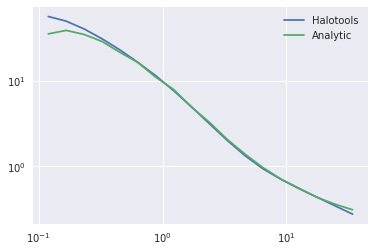

In [65]:
rpoints = (rp_bins[1:] + rp_bins[:-1])/2.0
plt.plot(rpoints, ds.squeeze(), label = 'Halotools')
plt.plot(rpoints, ds_analytic.squeeze(), label = 'Analytic')

plt.legend(loc='best')
plt.loglog();

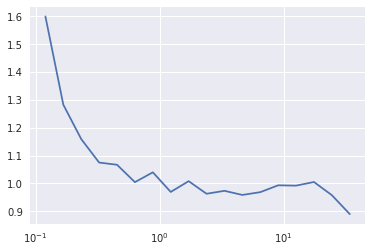

In [67]:
plt.plot(rpoints, ds.squeeze()/ds_analytic.squeeze(), )
plt.xscale('log')